# Supply chain partitioning example


In this notebook, we will use cuGraph to prototype partitioning of JDA supply chain example graph  

* Created:   11/3/2019
* Last Edit: 12/9/2019

RAPIDS Versions: 0.11.0

Test Hardware
* GV100 32G, CUDA 10.1

Using docker container: rapidsai/rapidsai-nightly:cuda10.1-runtime-centos7

## cuGraph Notice 
The current version of cuGraph has some limitations:

* Vertex IDs need to be 32-bit integers.
* Vertex IDs are expected to be contiguous integers starting from 0.

cuGraph provides the renumber function to mitigate this problem. Input vertex IDs for the renumber function can be either 32-bit or 64-bit integers, can be non-contiguous, and can start from an arbitrary number. The renumber function maps the provided input vertex IDs to 32-bit contiguous integers starting from 0. cuGraph still requires the renumbered vertex IDs to be representable in 32-bit integers. These limitations are being addressed and will be fixed soon. 

### Test Data
We will be using the example dataset Arijit provided.

### Prep

In [1]:
# Import needed libraries
import cugraph
import cudf
import numpy as np

In [2]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

### Read data using cuDF and pandas

In [3]:
# Test file    
datafile='../data/Arijit3.csv'

In [4]:
# read the data using cuDF
gdf = cudf.read_csv(datafile, delimiter=",", names=['src', 'dst'], dtype=['int32', 'int32'],skiprows=0)
df = pd.read_csv(datafile, delimiter=",", names=['src', 'dst'], skiprows=0)

In [5]:
gdf.to_pandas()

,src,dst
0,0,32
1,1,32
2,1,33
3,2,33
4,3,33
5,3,34
6,4,34
7,5,34
8,5,35
9,6,34


In [6]:
df.head()

,src,dst
0,0,32
1,1,32
2,1,33
3,2,33
4,3,33


### Create the directed graph using NetworkX

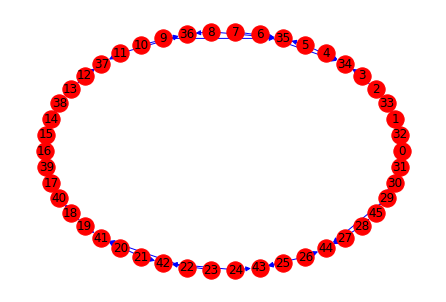

In [7]:
cpuG=nx.from_pandas_edgelist(df, source='src', target='dst',create_using=nx.DiGraph)
nx.draw(cpuG, with_labels=True,pos=nx.circular_layout(cpuG), node_color='r', edge_color='b')
plt.show()

In [8]:
print("cpu Graph")
print("\tNumber of Vertices: " + str(cpuG.number_of_nodes()))
print("\tNumber of Edges:    " + str(cpuG.number_of_edges()))

cpu Graph
	Number of Vertices: 46
	Number of Edges:    44


In [9]:
nx.is_strongly_connected(cpuG)

False

In [10]:
nx.is_weakly_connected(cpuG)

False

In [11]:
connectedskus = sorted(nx.weakly_connected_components(cpuG), key=len, reverse=True)

In [12]:
print("\tNumber weakly connected components: " + str(len(connectedskus)))

	Number weakly connected components: 2


In [13]:
# Generate WCCs of cpuG, returning a geneator of sets of nodes, one for each weakly connected component of G
[len(c) for c in sorted(nx.weakly_connected_components(cpuG), key=len, reverse=True)]

[23, 23]

In [14]:
nodeslist = []
for consku in connectedskus:
  nodeslist = []
  for val in consku:
          nodeslist.append(val)
  print(nodeslist)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 32, 33, 34, 35, 36, 37, 38]
[16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 39, 40, 41, 42, 43, 44, 45]


### Create the directed graph using cugraph

In [15]:
# we don't need to renumber for this dataset as the node index starts from 0 and contiguous 
gdf['renumbered_src'], gdf['renumbered_dst'], mapping = cugraph.renumber(gdf['src'], gdf['dst'])

In [16]:
# Note that currently cuGraph WCC only supported undirected network graph, so we use Graph() instead of DiGraph()
#gpuG = cugraph.DiGraph()
gpuG = cugraph.Graph()
gpuG.from_cudf_edgelist(gdf, source='renumbered_src', destination='renumbered_dst')

In [17]:
print("Main Graph")
print("\tNumber of Vertices: " + str(gpuG.number_of_vertices()))
print("\tNumber of Edges:    " + str(gpuG.number_of_edges()))

Main Graph
	Number of Vertices: 46
	Number of Edges:    88


In [18]:
# Generate WCCs of gpuG, returning cuda dataFrame df
# df[‘labels’][i] gives the label id of the ith vertex and df[‘vertices’][i] gives the vertex id of the i’th vertex
wcc = cugraph.weakly_connected_components(gpuG)

In [19]:
wcc['org_vertices'] = mapping[wcc['vertices']]

In [20]:
wcc

,labels,vertices,org_vertices
0,1,0,0
1,1,1,1
2,1,2,2
3,1,3,3
4,1,4,4
5,1,5,5
6,1,6,6
7,1,7,7
8,1,8,8
9,1,9,9


In [21]:
wcc['labels'].unique()

0     1
1    17
Name: labels, dtype: int32

In [22]:
label_gby = wcc.groupby('labels')

print("Total number of components found : ", wcc['labels'].unique().count())
print("Max # of nodes in any of the component : ", label_gby['org_vertices'].count().max())

Total number of components found :  2
Max # of nodes in any of the component :  23


In [23]:
label_gby['vertices'].count().max()

23

In [24]:
def print_components(_df, id, maxColumnLength):
    
    _f = _df.query('labels == @id')
  
    part = []
    for i in range(len(_f)):
        part.append(_f['vertices'][i])
        
    for i in range(len(_f), maxColumnLength):
        part.append(None)
    print(part)
    
    return part

In [25]:
tempdf = cudf.DataFrame()
for j in wcc['labels'].unique():
        print("Vertex Ids that belong to component label ", j, ": ") 
        
        tempdf['WCC'+str(j)] = print_components(wcc, j, label_gby['org_vertices'].count().max())

Vertex Ids that belong to component label  1 : 
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 32, 33, 34, 35, 36, 37, 38]
Vertex Ids that belong to component label  17 : 
[16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 39, 40, 41, 42, 43, 44, 45]
